In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import DataLoader, TensorDataset, random_split
import pyswarms as ps
import pygad

## 2D Rastrigin Approximation

In [40]:
# 2D
def Rastrigin(X):
    part = lambda a : a**2 - 10*np.cos(2*np.pi*a)
    summ = part(X[:,0]) + part(X[:,1])
    Z = 10*2 + summ 
    return Z

In [41]:
def generate_data(num_points):
    points = np.random.uniform(-5.12,5.12, size=(num_points, 2))
    func_out = Rastrigin(points)
    return points, func_out


In [42]:
def plot3d(xy,func_out):
    xy = np.array(xy)
    fig = plt.figure(figsize=(16,8))
    ax = fig.gca(projection='3d')
    ax.scatter(xy[:,0], xy[:,1], func_out)
    plt.show()

In [43]:
def plot2d(xy):
    xy = np.array(xy)
    fig = plt.figure(figsize=(16,8))
    plt.scatter(xy[:,0],xy[:,1])

In [44]:
class Model_2D(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Linear1 = nn.Linear(2,20)
        self.Linear2 = nn.Linear(20,50)
        self.Linear3= nn.Linear(50,120)   
        self.Linear4 = nn.Linear(120,70)
        self.Linear5 = nn.Linear(70,20)   
        self.Linear6= nn.Linear(20,10)
        self.output = nn.Linear(10,1)
        self.Relu = nn.ReLU()
        
    def forward(self,X):
        Xin = X
        
        if isinstance(X,np.ndarray):
            X = torch.from_numpy(X).double()
            
        X = self.Relu(self.Linear2(self.Relu(self.Linear1(X))))
        X = self.Relu(self.Linear3(X))
        X = self.Relu(self.Linear4(X))
        X = self.Relu(self.Linear5(X))
        X = self.Relu(self.Linear6(X))  
        output = self.output((X))
        
        if isinstance(Xin,np.ndarray):
            output = output.detach().numpy()
            output = output.squeeze()
            
        return output 


In [2]:
def train(model,train_loader,test_loader,checkpoint_path,num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = num_epochs
    best_loss = 1000
    batch_size = 8
    PATH = checkpoint_path
    train_loss_list = []
    test_loss_list = []
    for epoch in range(1,num_epochs+1):  # loop over the dataset multiple times
        running_loss = 0.0
        running_loss_test = 0.0
        for batch in train_loader:
            inputs, targets = batch
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            # loss computation
            loss = criterion(outputs.squeeze(),targets) 
            # backward pass
            loss.backward()

            # Perform a single optimization step (parameter update)
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print("Epoch {}/{}, Loss: {} ".format(epoch,num_epochs,running_loss/(len(train_loader)*batch_size)))
        
        train_loss_list.append(running_loss/(len(train_loader)*batch_size))   
        
        with torch.no_grad():
            for batch in test_loader:   # loop over the test dataset
                inputs, targets = batch
                outputs = model(inputs)
                # loss computation
                loss_test = criterion(outputs.squeeze(),targets) 
                running_loss_test += loss_test.item()
                
            avg_loss = running_loss_test/(len(test_loader)*batch_size)
            test_loss_list.append(avg_loss)
            
            if avg_loss < best_loss:
                best_loss = avg_loss
                torch.save(model.state_dict(), PATH)
                
    return [train_loss_list, test_loss_list]
    

       

In [3]:
def compute(X,Y,func):
    pred_array = np.zeros((50,50))
    for i in range(len(X)):
        for j in range(len(Y)):
            pred = func(np.array([[X[i],Y[j]]]))
            pred_array[j,i] = pred
    return pred_array

In [47]:
def plot_contours(model,pt):
    
    X = np.linspace(-1,1,50)
    Y = np.linspace(-1,1,50)
    Z1 = compute(X,Y,Rastrigin)
    Z2 = compute(X,Y,model)
    X,Y = np.meshgrid(X,Y)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.contourf(X,Y,Z1,20, cmap='RdGy')
    ax1.scatter(0,0) #actual minima
    ax2.contourf(X,Y,Z2,20, cmap='RdGy')
    ax2.scatter(0,0) #actual minima
    ax2.scatter(pt[0],pt[1])  
    plt.tight_layout() 
    plt.show()



In [48]:
def generate_data_types(num_points,minimum_pt, type_data):
    
    if type_data == "Dense_uniform":
        points = np.random.uniform(-5.12,5.12, size=(num_points, 2))
        
    elif type_data == "Sparse_uniform":
        num_points_sparse = int(0.25 * num_points)
        points = np.random.uniform(-5.12,5.12, size=(num_points_sparse, 2))
        
    elif type_data == "gaussian":
        mu, sigma = minimum_pt , np.ones((2)) * 5.12/3 # mean and standard deviation
        points = np.random.normal(mu,sigma, size=[num_points, 2])
        
    func_out = Rastrigin(points) #apply function 
    return points, func_out


In [49]:
def get_loaders_types(data_type):
    inputs_array, targets_array = generate_data_types(10000,[0,0], data_type)
    plot2d(inputs_array)
    plot3d(inputs_array, targets_array)
    inputs = torch.from_numpy(inputs_array)
    inputs = inputs.double()
    targets = torch.from_numpy(targets_array)
    targets = targets.double()
    dataset = TensorDataset(inputs, targets)
    train_size = int(0.8 * inputs.shape[0])
    test_size = inputs.shape[0] - train_size
    train_ds, test_ds = random_split(dataset,[train_size,test_size])
    batch_size = 8
    train_loader = DataLoader(train_ds, batch_size,drop_last=True ,shuffle=True)
    test_loader = DataLoader(test_ds, batch_size,drop_last=True)
    return train_loader, test_loader


In [4]:
def apply_swarm(model, dimension,i):
    # Create bounds
    np.random.seed(i)
    max_bound = np.ones(dimension) * 5.12
    min_bound = - max_bound
    bounds = (min_bound, max_bound)
    # Initialize swarm
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9} #mention setting in paper

    # Call instance of PSO with bounds argument
    optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimension, options=options, bounds=bounds)

    # Perform optimization
    cost, pos = optimizer.optimize(model, iters=1000)
    
    return pos

In [5]:
def apply_GA(model,dimension,i):
    Y = 0 

    def Fitness_func(solution, solution_idx):
        out = model(solution)
        fittness = 1.0 / (np.abs(out - Y) + 0.000001)
        return fittness

    
    ga_instance = pygad.GA(num_generations=100,  
                           num_parents_mating=2,
                           sol_per_pop=10,
                           num_genes=dimension,
                           fitness_func=Fitness_func,
                           init_range_low=-5.12,
                           init_range_high=5.12,
                           parent_selection_type="sss",
                       )
    np.random.seed(i)
    ga_instance.run()
    
    solution, solution_fittness, solution_idx = ga_instance.best_solution()
#     fig = ga_instance.plot_result()
#     plt.show()
    return solution

In [6]:
def apply_Optim_mean(dimension,model):
    sol_swarm_list = []
    sol_GA_list = []
    for i in range(5):
        pos = apply_swarm(model,dimension,np.random.randint(0,100))
        sol = apply_GA(model,dimension,np.random.randint(0,100))
        sol_swarm_list.append(pos)
        sol_GA_list.append(sol)
    return sol_swarm_list,sol_GA_list

In [7]:
def apply_Optim_mean_for_calc(dimension,model):
    sol_swarm_list = []
    sol_GA_list = []
    for i in range(10):
        pos = apply_swarm(model,dimension,np.random.randint(0,100))
        sol = apply_GA(model,dimension,np.random.randint(0,100))
        sol_swarm_list.append(pos)
        sol_GA_list.append(sol)
    return sol_swarm_list,sol_GA_list

# Dense

/tmp/ipykernel_2380827/1547251272.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


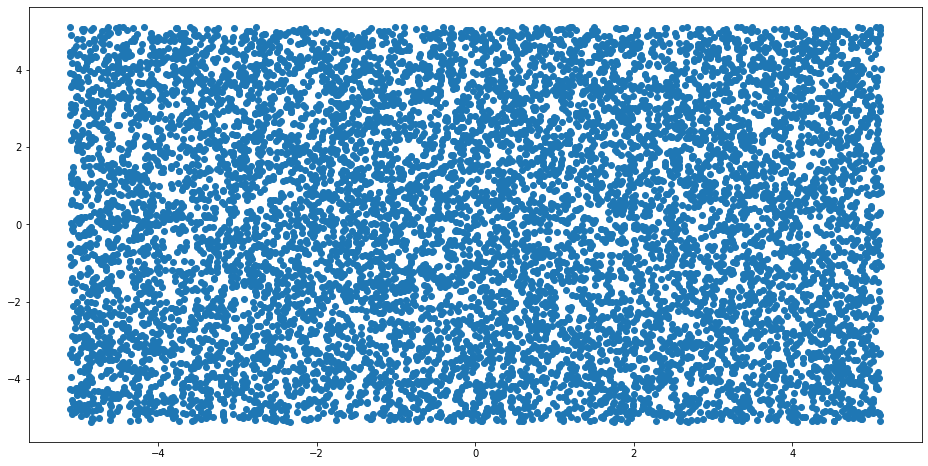

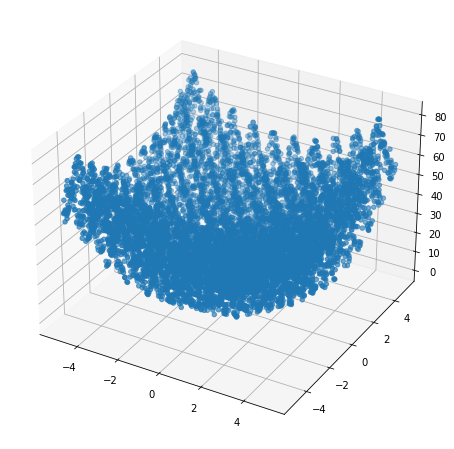

Epoch 1/500, Loss: 20.969816040600264 
Epoch 2/500, Loss: 13.198601793384716 
Epoch 3/500, Loss: 13.31296472661857 
Epoch 4/500, Loss: 13.091372368615028 
Epoch 5/500, Loss: 13.049084495303948 
Epoch 6/500, Loss: 13.099922895915817 
Epoch 7/500, Loss: 13.031984914624767 
Epoch 8/500, Loss: 12.882942299912159 
Epoch 9/500, Loss: 12.879858147020068 
Epoch 10/500, Loss: 13.002862604696947 
Epoch 11/500, Loss: 12.838295126985933 
Epoch 12/500, Loss: 12.875317813470355 
Epoch 13/500, Loss: 12.82761623141905 
Epoch 14/500, Loss: 12.905336932846767 
Epoch 15/500, Loss: 12.883348972512668 
Epoch 16/500, Loss: 12.830360332434761 
Epoch 17/500, Loss: 12.823271073709314 
Epoch 18/500, Loss: 12.789355746148349 
Epoch 19/500, Loss: 12.915319255342393 
Epoch 20/500, Loss: 12.77776390678646 
Epoch 21/500, Loss: 12.719101261370572 
Epoch 22/500, Loss: 12.834718570828619 
Epoch 23/500, Loss: 12.764909879214752 
Epoch 24/500, Loss: 12.801140361476744 
Epoch 25/500, Loss: 12.688589008121493 
Epoch 26/500

In [70]:
model_dense = Model_2D().double()
train_loader,test_loader = get_loaders_types("Dense_uniform")
output_1 = train(model_dense,train_loader,test_loader,"Rastrigin_dense.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

In [71]:
PATH_dense = "Rastrigin_dense.pth"
model_dense = Model_2D().double()
model_dense.load_state_dict(torch.load(PATH_dense))

<All keys matched successfully>

In [72]:
ls1,ls2 = apply_Optim_mean(2,model_dense)
ls1

2022-09-25 15:56:27,816 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=2.78
2022-09-25 15:56:29,449 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.779781206701584, best pos: [-8.84475039e-01 -7.59320707e-04]
2022-09-25 15:56:29,793 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=2.78
2022-09-25 15:56:31,481 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.779781206701584, best pos: [0.86479211 0.00987199]
2022-09-25 15:56:31,846 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=2.78
2022-09-25 15:56:33,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.

[array([-8.84475039e-01, -7.59320707e-04]),
 array([0.86479211, 0.00987199]),
 array([-0.00779715, -0.12592018]),
 array([ 0.98618374, -0.08530509]),
 array([ 0.98728966, -0.06498998])]

In [68]:
def plot_contours_modified(model,PS_list,GA_list):
    
    X = np.linspace(-2,2,50)
    Y = np.linspace(-2,2,50)
    Z1 = compute(X,Y,Rastrigin)
    Z2 = compute(X,Y,model)
    Z3 = Z2
    X,Y = np.meshgrid(X,Y)
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(10,5))
    ax1.contourf(X,Y,Z1,20, cmap='RdGy')
    ax1.scatter(0,0,color="red")
    ax2.contourf(X,Y,Z2,20, cmap='RdGy')
    ax2.scatter(0,0,color="red")
    ax2.scatter(PS_list[0][0],PS_list[0][1])  
    ax2.scatter(PS_list[1][0],PS_list[1][1])  
    ax2.scatter(PS_list[2][0],PS_list[2][1])  
    ax2.scatter(PS_list[3][0],PS_list[3][1])  
    ax2.scatter(PS_list[4][0],PS_list[4][1])
    ax3.contourf(X,Y,Z3,20, cmap='RdGy')
    ax3.scatter(0,0,color="red")
    ax3.scatter(GA_list[0][0],GA_list[0][1])  
    ax3.scatter(GA_list[1][0],GA_list[1][1])  
    ax3.scatter(GA_list[2][0],GA_list[2][1])  
    ax3.scatter(GA_list[3][0],GA_list[3][1])  
    ax3.scatter(GA_list[4][0],GA_list[4][1]) 

    plt.tight_layout() 
    plt.show()



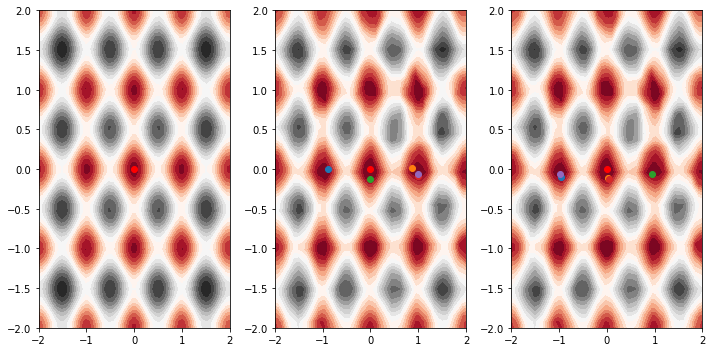

In [73]:
plot_contours_modified(model_dense,ls1,ls2)

# Sparse

/tmp/ipykernel_2380827/1547251272.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


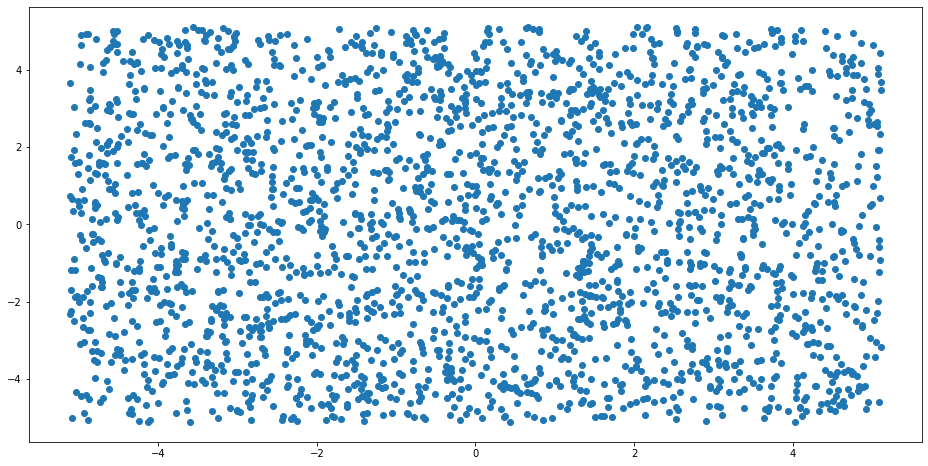

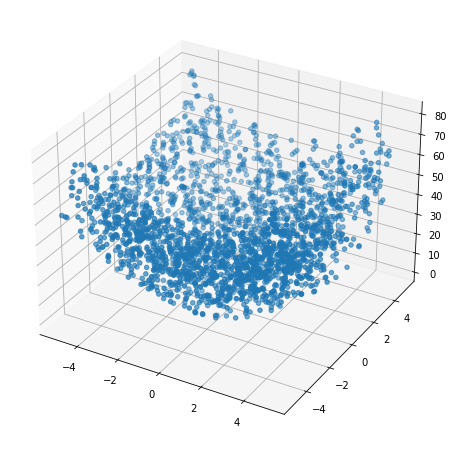

Epoch 1/500, Loss: 44.5584776303145 
Epoch 2/500, Loss: 13.065654729783914 
Epoch 3/500, Loss: 12.93863240147162 
Epoch 4/500, Loss: 13.29951611038144 
Epoch 5/500, Loss: 13.041602179285736 
Epoch 6/500, Loss: 12.87428695352569 
Epoch 7/500, Loss: 12.880986370471868 
Epoch 8/500, Loss: 12.739161770734837 
Epoch 9/500, Loss: 13.060232055659084 
Epoch 10/500, Loss: 12.853083055237382 
Epoch 11/500, Loss: 12.901972663507987 
Epoch 12/500, Loss: 12.675244918727474 
Epoch 13/500, Loss: 12.770067495544803 
Epoch 14/500, Loss: 12.74582075943845 
Epoch 15/500, Loss: 12.720566926127605 
Epoch 16/500, Loss: 12.957823933231824 
Epoch 17/500, Loss: 12.697001881206367 
Epoch 18/500, Loss: 12.61434834072711 
Epoch 19/500, Loss: 12.575277408653152 
Epoch 20/500, Loss: 12.77059338259567 
Epoch 21/500, Loss: 12.454765839693335 
Epoch 22/500, Loss: 12.647130088271545 
Epoch 23/500, Loss: 12.514855211266722 
Epoch 24/500, Loss: 12.681681790372842 
Epoch 25/500, Loss: 12.668963991706002 
Epoch 26/500, Los

In [ ]:
model_sparse = Model_2D().double()
train_loader,test_loader = get_loaders_types("Sparse_uniform")
output_1 = train(model_sparse,train_loader,test_loader,"Rastrigin_sparse.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

In [ ]:
PATH_sparse = "Rastrigin_sparse.pth"
model_sparse = Model_2D().double()
model_sparse.load_state_dict(torch.load(PATH_sparse))

<All keys matched successfully>

In [ ]:
ls1_sparse,ls2_sparse = apply_Optim_mean(2,model_sparse)
ls1_sparse

2022-09-25 14:47:59,641 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.727
2022-09-25 14:48:01,413 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7274454219848737, best pos: [-1.12283228  0.858518  ]
2022-09-25 14:48:01,768 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.727
2022-09-25 14:48:03,630 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7274454219848737, best pos: [-1.12283228  0.858518  ]
2022-09-25 14:48:03,986 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.727
2022-09-25 14:48:05,685 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7

[array([-1.12283228,  0.858518  ]),
 array([-1.12283228,  0.858518  ]),
 array([-1.12283228,  0.858518  ]),
 array([-1.12283228,  0.858518  ]),
 array([-1.12283228,  0.858518  ])]

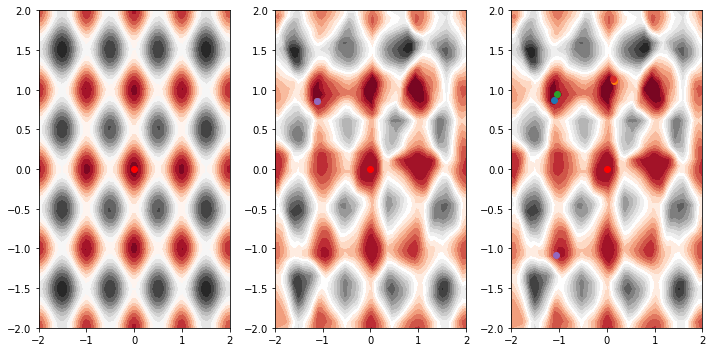

In [ ]:
plot_contours_modified(model_sparse,ls1_sparse,ls2_sparse)

In [8]:
from scipy.spatial import distance

def mean_std(dimension,model):
    
    sol_swarm_list,sol_GA_list = apply_Optim_mean_for_calc(dimension,model)
    min_pt = np.zeros((dimension))
    swarm_dist = [] 
    GA_dist = []
    for i in range(10):
        swarm_dist.append(distance.euclidean(min_pt,sol_swarm_list[i]))
        GA_dist.append(distance.euclidean(min_pt,sol_GA_list[i]))
        
    mean_swarm_dist = np.mean(swarm_dist)
    std_swarm_dist = np.std(swarm_dist)
   
    mean_GA_dist= np.mean(GA_dist)
    std_GA_dist = np.std(GA_dist)
    
    return mean_swarm_dist,std_swarm_dist,mean_GA_dist,std_GA_dist
    

In [ ]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse = mean_std(2,model_sparse)

2022-09-25 14:49:16,443 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.727
2022-09-25 14:49:18,316 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.727445421984874, best pos: [-1.12283228  0.858518  ]
2022-09-25 14:49:18,672 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.727
2022-09-25 14:49:20,556 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7274454219848737, best pos: [-1.12283228  0.858518  ]
2022-09-25 14:49:20,913 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.727
2022-09-25 14:49:22,901 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.72

In [ ]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse

(1.4134374685011188,
 2.220446049250313e-16,
 1.2418591120317561,
 0.12722055167211033)

In [74]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense = mean_std(2,model_dense)

2022-09-25 15:57:22,901 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=2.78
2022-09-25 15:57:24,857 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.779781206701584, best pos: [ 1.00957081 -0.0384976 ]
2022-09-25 15:57:25,229 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=2.78
2022-09-25 15:57:27,019 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.779781206701584, best pos: [-0.93308558 -0.91952896]
2022-09-25 15:57:27,366 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=2.78
2022-09-25 15:57:29,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.779781

In [75]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense

(0.7480471172963574,
 0.42242655701110815,
 1.161922030141966,
 0.21676330969899824)

# Gauss


/tmp/ipykernel_2380827/1547251272.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


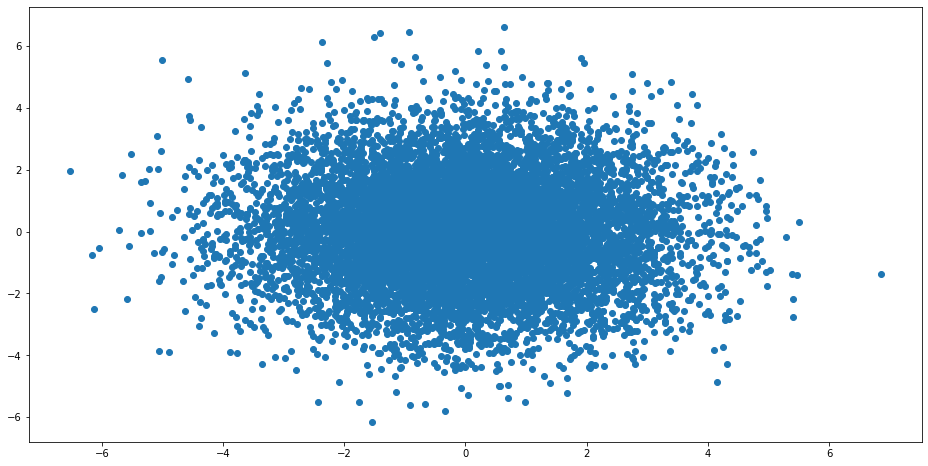

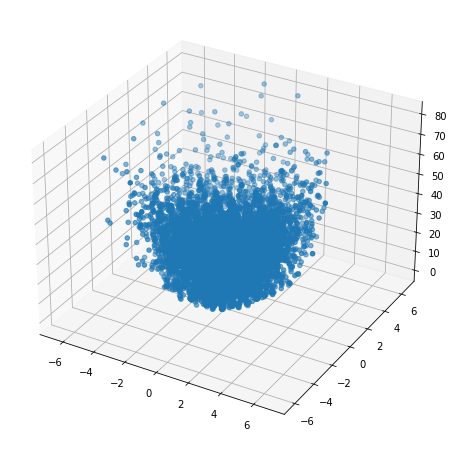

Epoch 1/500, Loss: 17.828864240432242 
Epoch 2/500, Loss: 13.391446593330528 
Epoch 3/500, Loss: 13.139021448185158 
Epoch 4/500, Loss: 13.217337605110734 
Epoch 5/500, Loss: 13.086502904972564 
Epoch 6/500, Loss: 12.962660768484206 
Epoch 7/500, Loss: 12.974093802924484 
Epoch 8/500, Loss: 12.83031275216676 
Epoch 9/500, Loss: 12.868044082627225 
Epoch 10/500, Loss: 12.65388757269451 
Epoch 11/500, Loss: 12.663549513334894 
Epoch 12/500, Loss: 12.594600726752773 
Epoch 13/500, Loss: 12.476536239509297 
Epoch 14/500, Loss: 12.38785868958177 
Epoch 15/500, Loss: 12.222866804020851 
Epoch 16/500, Loss: 12.253857867082147 
Epoch 17/500, Loss: 12.075567507049616 
Epoch 18/500, Loss: 11.950488342464698 
Epoch 19/500, Loss: 11.82105899718564 
Epoch 20/500, Loss: 11.60304459129595 
Epoch 21/500, Loss: 11.413678838111634 
Epoch 22/500, Loss: 11.195025948069214 
Epoch 23/500, Loss: 10.73512512972602 
Epoch 24/500, Loss: 10.592754220113568 
Epoch 25/500, Loss: 10.274720352362179 
Epoch 26/500, L

In [60]:
model_gauss = Model_2D().double()
train_loader,test_loader = get_loaders_types("gaussian")
output_1 = train(model_gauss,train_loader,test_loader,"Rastrigin_gauss.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

In [61]:
PATH_gauss = "Rastrigin_gauss.pth"
model_gauss = Model_2D().double()
model_gauss.load_state_dict(torch.load(PATH_gauss))

<All keys matched successfully>

In [62]:
ls1_gauss,ls2_gauss = apply_Optim_mean(2,model_gauss)
ls1_gauss

2022-09-25 15:27:37,595 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.74
2022-09-25 15:27:39,432 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.7421871638107724, best pos: [-0.94042719  0.07001555]
2022-09-25 15:27:39,784 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.74
2022-09-25 15:27:41,759 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.7421871638107724, best pos: [-6.87835707e-04 -9.66662286e-01]
2022-09-25 15:27:42,140 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.74
2022-09-25 15:27:43,921 - pyswarms.single.global_best - INFO - Optimization finished | best cost

[array([-0.94042719,  0.07001555]),
 array([-6.87835707e-04, -9.66662286e-01]),
 array([-0.95773388,  0.02407769]),
 array([0.01810366, 1.01829094]),
 array([-0.00706021,  0.01381334])]

In [52]:
ls1_gauss,ls2_gauss

([array([0.0081677 , 0.29611606]),
  array([-0.76923234,  0.76502603]),
  array([-0.61928687,  0.33200787]),
  array([1.06914319, 1.15269791]),
  array([0.92410619, 0.77189557])],
 [array([ 0.37718372, -0.20722706]),
  array([-0.43069101,  0.28828865]),
  array([0.12725837, 0.17361494]),
  array([0.48828538, 0.23423914]),
  array([0.00161754, 0.24115592])])

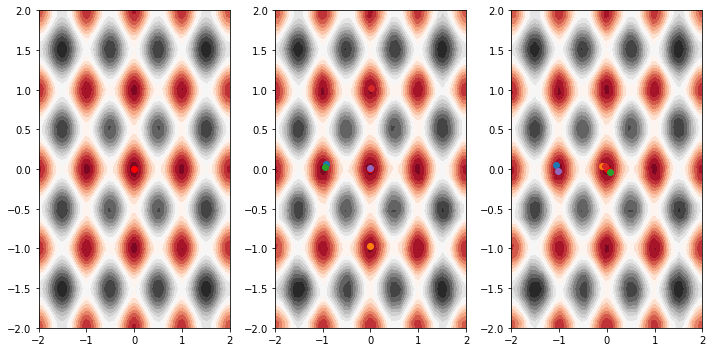

In [63]:
plot_contours_modified(model_gauss,ls1_gauss,ls2_gauss)

In [55]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss = mean_std(2,model_gauss)

2022-09-24 11:18:43,768 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0   
2022-09-24 11:18:45,597 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [0.0081677  0.29611606]
2022-09-24 11:18:45,837 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-24 11:18:47,631 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.76923234  0.76502603]
2022-09-24 11:18:47,865 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0
2022-09-24 11:18:49,787 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-0.61928687  0.33200787]
202

In [56]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss 

(1.0695166619813556,
 0.5401367312241688,
 1.1527648835540714,
 0.2760967949080978)

# 4D Rastrigin


In [9]:
class Model_4D(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Linear1 = nn.Linear(4,20)
        self.Linear2 = nn.Linear(20,50)
        self.Linear3= nn.Linear(50,120)   
        self.Linear4 = nn.Linear(120,70)
        self.Linear5 = nn.Linear(70,20)   
        self.Linear6= nn.Linear(20,10)
        self.output = nn.Linear(10,1)
        self.Relu = nn.ReLU()
        
    def forward(self,X):
        Xin = X
        
        if isinstance(X,np.ndarray):
            X = torch.from_numpy(X).double()
            
        X = self.Relu(self.Linear2(self.Relu(self.Linear1(X))))
        X = self.Relu(self.Linear3(X))
        X = self.Relu(self.Linear4(X))
        X = self.Relu(self.Linear5(X))
        X = self.Relu(self.Linear6(X))  
        output = self.output((X))
        
        if isinstance(Xin,np.ndarray):
            output = output.detach().numpy()
            output = output.squeeze()
            
        return output 

In [10]:
# 4D

def Rastrigin4D(X):
    part = lambda a : a**2 - 10*np.cos(2*np.pi*a)
    summ = part(X[:,0]) + part(X[:,1]) + part(X[:,2]) + part(X[:,3])
    Z = 10*4 + summ 
    return Z

In [11]:
def get_loaders_types(data_type):
    inputs_array, targets_array = generate_data_types(10000,[0,0,0,0], data_type)
#     plot2d(inputs_array)
#     plot3d(inputs_array, targets_array)
    inputs = torch.from_numpy(inputs_array)
    inputs = inputs.double()
    targets = torch.from_numpy(targets_array)
    targets = targets.double()
    dataset = TensorDataset(inputs, targets)
    train_size = int(0.8 * inputs.shape[0])
    test_size = inputs.shape[0] - train_size
    train_ds, test_ds = random_split(dataset,[train_size,test_size])
    batch_size = 8
    train_loader = DataLoader(train_ds, batch_size,drop_last=True ,shuffle=True)
    test_loader = DataLoader(test_ds, batch_size,drop_last=True)
    return train_loader, test_loader



In [13]:
def generate_data_types(num_points,minimum_pt, type_data):
    
    if type_data == "Dense_uniform":
        points = np.random.uniform(-5.12,5.12, size=(num_points, 4))
        
    elif type_data == "Sparse_uniform":
        num_points_sparse = int(0.25 * num_points)
        points = np.random.uniform(-5.12,5.12, size=(num_points_sparse, 4))
        
    elif type_data == "gaussian":
        mu, sigma = minimum_pt , np.ones((4)) * 5.12/3 # mean and standard deviation
        points = np.random.normal(mu,sigma, size=[num_points, 4])
        
    func_out = Rastrigin4D(points) #apply function 
    return points, func_out


In [14]:
model_dense = Model_4D().double()
train_loader,test_loader = get_loaders_types("Dense_uniform")
output_1 = train(model_dense,train_loader,test_loader,"Ras_dense_4.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

Epoch 1/500, Loss: 57.983722287807595 
Epoch 2/500, Loss: 27.54593192711175 
Epoch 3/500, Loss: 26.851837058055164 
Epoch 4/500, Loss: 27.129593487071627 
Epoch 5/500, Loss: 26.96625112178264 
Epoch 6/500, Loss: 26.782834263158303 
Epoch 7/500, Loss: 26.364629233985827 
Epoch 8/500, Loss: 26.883833946167144 
Epoch 9/500, Loss: 25.890871172554668 
Epoch 10/500, Loss: 26.304283200321308 
Epoch 11/500, Loss: 26.180958658465734 
Epoch 12/500, Loss: 26.545830509319224 
Epoch 13/500, Loss: 26.0334141328144 
Epoch 14/500, Loss: 26.304231264238332 
Epoch 15/500, Loss: 26.14776332377187 
Epoch 16/500, Loss: 26.320549184161493 
Epoch 17/500, Loss: 25.976205521556576 
Epoch 18/500, Loss: 25.952591700523293 
Epoch 19/500, Loss: 25.78665715385402 
Epoch 20/500, Loss: 25.91121600198733 
Epoch 21/500, Loss: 25.760508261450667 
Epoch 22/500, Loss: 26.067266686583427 
Epoch 23/500, Loss: 25.792032221863344 
Epoch 24/500, Loss: 25.88129189573681 
Epoch 25/500, Loss: 25.816475186187127 
Epoch 26/500, Los

In [15]:
PATH_dense = "Ras_dense_4.pth"
model_dense = Model_4D().double()
model_dense.load_state_dict(torch.load(PATH_dense))

<All keys matched successfully>

In [16]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense = mean_std(4,model_dense)

2022-09-25 18:23:55,225 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=28
2022-09-25 18:23:57,364 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 28.027141529119287, best pos: [ 0.14333363 -0.37256457 -0.22067635 -0.11769759]
/home/fatima.albreiki/.conda/envs/CV703/lib/python3.9/site-packages/pygad/pygad.py:473: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutatio

In [17]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense 

(0.4708990095130791,
 0.000163257591694832,
 0.442474204752176,
 0.028122833950544077)

In [18]:
model_sparse = Model_4D().double()
train_loader,test_loader = get_loaders_types("Sparse_uniform")
output_1 = train(model_sparse,train_loader,test_loader,"Ras_sparse_4.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

Epoch 1/500, Loss: 250.43165320947702 
Epoch 2/500, Loss: 30.798489415925744 
Epoch 3/500, Loss: 30.165268092721696 
Epoch 4/500, Loss: 29.243610538597455 
Epoch 5/500, Loss: 29.829883072532066 
Epoch 6/500, Loss: 28.927782448206006 
Epoch 7/500, Loss: 28.671346449246595 
Epoch 8/500, Loss: 29.08520087437394 
Epoch 9/500, Loss: 29.523604364683898 
Epoch 10/500, Loss: 28.88531289769201 
Epoch 11/500, Loss: 28.89625081588558 
Epoch 12/500, Loss: 28.858065719370355 
Epoch 13/500, Loss: 29.01758217590584 
Epoch 14/500, Loss: 28.590386632758555 
Epoch 15/500, Loss: 28.070645303746833 
Epoch 16/500, Loss: 28.44580461136484 
Epoch 17/500, Loss: 28.45406126782774 
Epoch 18/500, Loss: 28.294996569410728 
Epoch 19/500, Loss: 28.03019759686488 
Epoch 20/500, Loss: 28.215969121860635 
Epoch 21/500, Loss: 28.227210269206633 
Epoch 22/500, Loss: 27.598044588082193 
Epoch 23/500, Loss: 28.64330609750042 
Epoch 24/500, Loss: 27.84037098990785 
Epoch 25/500, Loss: 27.581896389679233 
Epoch 26/500, Loss

In [19]:
PATH_sparse = "Ras_sparse_4.pth"
model_sparse = Model_4D().double()
model_sparse.load_state_dict(torch.load(PATH_sparse))

<All keys matched successfully>

In [20]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse = mean_std(4,model_sparse)

2022-09-25 18:30:39,407 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=21.8
2022-09-25 18:30:41,063 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 21.755093265859706, best pos: [-0.0373719   0.19179243 -0.58607985  0.37289085]
2022-09-25 18:30:41,405 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=21.8
2022-09-25 18:30:43,171 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 21.754742255433648, best pos: [-0.03458669  0.18625333 -0.58765246  0.36571962]
2022-09-25 18:30:43,502 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=21.8
2022-09-25 18:30:45,458 - pyswarms.single.global_best - 

In [21]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse

(0.7238526633054894,
 0.008243911328124643,
 0.707132065099661,
 0.020424181090006596)

In [22]:
model_gauss = Model_4D().double()
train_loader,test_loader = get_loaders_types("gaussian")
output_1 = train(model_gauss,train_loader,test_loader,"Ras_gauss_4.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

Epoch 1/500, Loss: 46.914793754869 
Epoch 2/500, Loss: 26.731928949636313 
Epoch 3/500, Loss: 26.560483743129296 
Epoch 4/500, Loss: 26.486620022027136 
Epoch 5/500, Loss: 26.543118768488373 
Epoch 6/500, Loss: 26.431289301495536 
Epoch 7/500, Loss: 26.353119090914962 
Epoch 8/500, Loss: 26.401531039454714 
Epoch 9/500, Loss: 26.2127496617262 
Epoch 10/500, Loss: 26.313713634142367 
Epoch 11/500, Loss: 26.158843473773373 
Epoch 12/500, Loss: 26.230758953126212 
Epoch 13/500, Loss: 26.104582589092704 
Epoch 14/500, Loss: 26.075100055239233 
Epoch 15/500, Loss: 26.21237272046629 
Epoch 16/500, Loss: 26.193701065720642 
Epoch 17/500, Loss: 26.06729655704886 
Epoch 18/500, Loss: 26.12925765198258 
Epoch 19/500, Loss: 26.049396868382956 
Epoch 20/500, Loss: 25.877466951995093 
Epoch 21/500, Loss: 25.925122102627075 
Epoch 22/500, Loss: 25.850059468067194 
Epoch 23/500, Loss: 26.048730942325246 
Epoch 24/500, Loss: 25.848017606572913 
Epoch 25/500, Loss: 25.934933513227424 
Epoch 26/500, Los

In [23]:
PATH_gauss = "Ras_gauss_4.pth"
model_gauss = Model_4D().double()
model_gauss.load_state_dict(torch.load(PATH_gauss))

<All keys matched successfully>

In [24]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss = mean_std(4,model_gauss)

2022-09-25 18:50:22,965 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=38.9
2022-09-25 18:50:24,990 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 38.887589881390355, best pos: [0.61316304 0.14305862 0.20365067 0.25569827]
2022-09-25 18:50:25,336 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=38.9
2022-09-25 18:50:27,193 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 38.887589881390355, best pos: [0.61316304 0.14305862 0.20365067 0.25569827]
2022-09-25 18:50:27,548 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=38.9
2022-09-25 18:50:29,232 - pyswarms.single.global_best - INFO - O

In [25]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss

(0.7094292683620174,
 2.144196810752504e-15,
 0.6730099643002971,
 0.05003246005724923)

# 10D Rastrigin

In [26]:
class Model_10D(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Linear1 = nn.Linear(10,20)
        self.Linear2 = nn.Linear(20,50)
        self.Linear3= nn.Linear(50,120)   
        self.Linear4 = nn.Linear(120,70)
        self.Linear5 = nn.Linear(70,20)   
        self.Linear6= nn.Linear(20,10)
        self.output = nn.Linear(10,1)
        self.Relu = nn.ReLU()
        
    def forward(self,X):
        Xin = X
        
        if isinstance(X,np.ndarray):
            X = torch.from_numpy(X).double()
            
        X = self.Relu(self.Linear2(self.Relu(self.Linear1(X))))
        X = self.Relu(self.Linear3(X))
        X = self.Relu(self.Linear4(X))
        X = self.Relu(self.Linear5(X))
        X = self.Relu(self.Linear6(X))  
        output = self.output((X))
        
        if isinstance(Xin,np.ndarray):
            output = output.detach().numpy()
            output = output.squeeze()
            
        return output 

In [27]:
# 10D

def Rastrigin10D(X):
    part = lambda a : a**2 - 10*np.cos(2*np.pi*a)
    summ = part(X[:,0]) + part(X[:,1]) + part(X[:,2]) + part(X[:,3])
    Z = 10*10 + summ 
    return Z

In [28]:
def generate_data_types(num_points,minimum_pt, type_data):
    
    if type_data == "Dense_uniform":
        points = np.random.uniform(-5.12,5.12, size=(num_points, 10))
        
    elif type_data == "Sparse_uniform":
        num_points_sparse = int(0.25 * num_points)
        points = np.random.uniform(-5.12,5.12, size=(num_points_sparse, 10))
        
    elif type_data == "gaussian":
        mu, sigma = minimum_pt , np.ones((10)) * 5.12/3 # mean and standard deviation
        points = np.random.normal(mu,sigma, size=[num_points, 10])
        
    func_out = Rastrigin10D(points) #apply function 
    return points, func_out



In [29]:
def get_loaders_types(data_type):
    pt = np.zeros(10)
    inputs_array, targets_array = generate_data_types(10000,pt, data_type)
#     plot2d(inputs_array)
#     plot3d(inputs_array, targets_array)
    inputs = torch.from_numpy(inputs_array)
    inputs = inputs.double()
    targets = torch.from_numpy(targets_array)
    targets = targets.double()
    dataset = TensorDataset(inputs, targets)
    train_size = int(0.8 * inputs.shape[0])
    test_size = inputs.shape[0] - train_size
    train_ds, test_ds = random_split(dataset,[train_size,test_size])
    batch_size = 8
    train_loader = DataLoader(train_ds, batch_size,drop_last=True ,shuffle=True)
    test_loader = DataLoader(test_ds, batch_size,drop_last=True)
    return train_loader, test_loader



In [30]:
model_dense = Model_10D().double()
train_loader,test_loader = get_loaders_types("Dense_uniform")
output_1 = train(model_dense,train_loader,test_loader,"Ras_dense_10.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]


Epoch 1/500, Loss: 171.890124442538 
Epoch 2/500, Loss: 34.28538665493127 
Epoch 3/500, Loss: 30.649620223966224 
Epoch 4/500, Loss: 29.651721643341364 
Epoch 5/500, Loss: 28.874946509037432 
Epoch 6/500, Loss: 28.88480663888338 
Epoch 7/500, Loss: 27.995528701563973 
Epoch 8/500, Loss: 27.856156249760417 
Epoch 9/500, Loss: 28.767782391325106 
Epoch 10/500, Loss: 27.60099511796239 
Epoch 11/500, Loss: 28.138785472968667 
Epoch 12/500, Loss: 27.46602867464438 
Epoch 13/500, Loss: 27.742956512621245 
Epoch 14/500, Loss: 27.64088785338295 
Epoch 15/500, Loss: 27.181828398365177 
Epoch 16/500, Loss: 27.252854327386448 
Epoch 17/500, Loss: 27.325497801244474 
Epoch 18/500, Loss: 27.190445271016582 
Epoch 19/500, Loss: 27.319624194674073 
Epoch 20/500, Loss: 27.355743615532123 
Epoch 21/500, Loss: 26.85294768305161 
Epoch 22/500, Loss: 26.93091120247852 
Epoch 23/500, Loss: 26.567932084489453 
Epoch 24/500, Loss: 26.782582905798233 
Epoch 25/500, Loss: 26.722164353810715 
Epoch 26/500, Loss

In [31]:
PATH_dense = "Ras_dense_10.pth"
model_dense = Model_10D().double()
model_dense.load_state_dict(torch.load(PATH_dense))


<All keys matched successfully>

In [32]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense = mean_std(10,model_dense)
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense 

2022-09-25 19:26:54,637 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=83.2
2022-09-25 19:26:56,610 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 83.19083846597425, best pos: [ 0.26175032  0.00986439  0.05574581  0.04832657 -0.11671785  0.77794456
  2.32104805  0.0691439  -1.63171766 -0.5046518 ]
2022-09-25 19:26:57,050 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=83.4
2022-09-25 19:26:58,851 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 83.44657239268508, best pos: [ 0.77479192 -0.18949788  0.17284536  0.20781114  0.24175583  2.3811239
  0.94705663 -0.7477556  -2.896601    0.52721386]
2022-09-25 19:26:59,235 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2':

(3.6855438742778013, 0.529808921566689, 4.459864916256832, 1.06603963154114)

In [33]:
model_sparse = Model_10D().double()
train_loader,test_loader = get_loaders_types("Sparse_uniform")
output_1 = train(model_sparse,train_loader,test_loader,"Ras_sparse_10.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]


Epoch 1/500, Loss: 558.9339137924133 
Epoch 2/500, Loss: 64.45198028443563 
Epoch 3/500, Loss: 50.20116627691214 
Epoch 4/500, Loss: 42.28726622041644 
Epoch 5/500, Loss: 38.799029373281435 
Epoch 6/500, Loss: 34.37653487332673 
Epoch 7/500, Loss: 32.488838005341485 
Epoch 8/500, Loss: 30.917141363460466 
Epoch 9/500, Loss: 30.808418307877233 
Epoch 10/500, Loss: 29.604656175842784 
Epoch 11/500, Loss: 28.9087166650098 
Epoch 12/500, Loss: 29.4930606925131 
Epoch 13/500, Loss: 28.73537428174733 
Epoch 14/500, Loss: 29.096959334286385 
Epoch 15/500, Loss: 27.859816235475243 
Epoch 16/500, Loss: 28.3409628373571 
Epoch 17/500, Loss: 28.3883181935848 
Epoch 18/500, Loss: 27.657448906908762 
Epoch 19/500, Loss: 27.839385506211805 
Epoch 20/500, Loss: 27.311584510888856 
Epoch 21/500, Loss: 26.910142023953092 
Epoch 22/500, Loss: 27.385123668176867 
Epoch 23/500, Loss: 26.66152082678752 
Epoch 24/500, Loss: 27.40862185615896 
Epoch 25/500, Loss: 26.147538962230406 
Epoch 26/500, Loss: 26.84

In [34]:
PATH_sparse = "Ras_sparse_10.pth"
model_sparse = Model_10D().double()
model_sparse.load_state_dict(torch.load(PATH_sparse))


<All keys matched successfully>

In [35]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse = mean_std(10,model_sparse)
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse 

2022-09-25 19:32:26,016 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=73 
2022-09-25 19:32:27,784 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 72.95805224789997, best pos: [-0.15028896 -0.28878124 -0.07894171  0.11555316  0.60936561  0.2438878
  2.04727402 -0.08294357 -0.46658489 -0.20133358]
2022-09-25 19:32:28,118 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=73.1
2022-09-25 19:32:29,977 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 73.12616914110734, best pos: [-2.18106735e-01 -3.69415862e-01 -1.50277808e-03  1.17414827e-01
  5.95116697e-01  4.28517292e-01  1.91801627e+00 -1.85178678e-01
 -4.68620732e-02  2.28382359e-01]
2022-09-25 19:32:30,396 - pyswarms.single.global_best - INFO - Optimi

(2.200353032914392, 0.28823590254791837, 2.362077433997523, 0.5607441671937322)

In [36]:
model_gauss = Model_10D().double()
train_loader,test_loader = get_loaders_types("gaussian")
output_1 = train(model_gauss,train_loader,test_loader,"Ras_gauss_10.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]


Epoch 1/500, Loss: 134.3610905519004 
Epoch 2/500, Loss: 29.95991299677833 
Epoch 3/500, Loss: 27.733927509229936 
Epoch 4/500, Loss: 27.010564378632907 
Epoch 5/500, Loss: 27.690022879158782 
Epoch 6/500, Loss: 27.159386081272064 
Epoch 7/500, Loss: 26.776947687314625 
Epoch 8/500, Loss: 26.928420585037063 
Epoch 9/500, Loss: 26.739007356184413 
Epoch 10/500, Loss: 26.537584267996493 
Epoch 11/500, Loss: 26.339580675679933 
Epoch 12/500, Loss: 26.47992118226254 
Epoch 13/500, Loss: 26.399500049723986 
Epoch 14/500, Loss: 26.416365666485525 
Epoch 15/500, Loss: 26.220441788813 
Epoch 16/500, Loss: 26.09348530562059 
Epoch 17/500, Loss: 26.166983836937817 
Epoch 18/500, Loss: 25.973868281264295 
Epoch 19/500, Loss: 26.134090974941085 
Epoch 20/500, Loss: 26.318081179504443 
Epoch 21/500, Loss: 25.411832430288168 
Epoch 22/500, Loss: 25.692261788519772 
Epoch 23/500, Loss: 25.967612436314628 
Epoch 24/500, Loss: 25.507816847451625 
Epoch 25/500, Loss: 25.473362999744488 
Epoch 26/500, Lo

In [37]:
PATH_gauss = "Ras_gauss_10.pth"
model_gauss = Model_10D().double()
model_gauss.load_state_dict(torch.load(PATH_gauss))



<All keys matched successfully>

In [38]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss = mean_std(10,model_gauss)
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss

2022-09-25 19:53:54,244 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=91.2
2022-09-25 19:53:56,142 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 91.21604350743522, best pos: [ 0.76517643 -0.25245725 -0.35829534 -0.07871629  2.97747352 -2.23933367
 -0.26530274  4.57209544  0.40633902 -1.57274844]
2022-09-25 19:53:56,486 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=91.4
2022-09-25 19:53:58,298 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 91.42377474478553, best pos: [ 0.73193424 -0.267577   -0.48552852 -0.39581029  2.39585843 -1.45340013
  0.79062248  4.93162112 -0.33449206 -0.8041825 ]
2022-09-25 19:53:58,648 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2'

(6.2568810285805965,
 0.43313517614490243,
 7.9078781954164175,
 2.663914239382988)

# END